In [1]:
from dynmodes import *
from matplotlib import pyplot as plt
import xarray as xr
from tqdm import tqdm as progressbar

In [2]:
def density_profile(depth):
    """Return a density profile as described in eq 50 of McCreary (1980)."""
    rho_0 = 1.028
    d_rho_1 = 0.003
    d_rho_2 = 0.002
    b_1 = 200.
    b_2 = 1000.
    H = 75.
    rho = rho_0 + d_rho_1 * (1 - np.exp(-(depth - H) / b_1)) + d_rho_2 * (1 - np.exp(-(depth - H) / b_2))
    rho[np.where(depth < 75.)] = rho_0
    return rho

In [3]:
depth = np.linspace(0, 1500, 151)
rho = density_profile(depth)

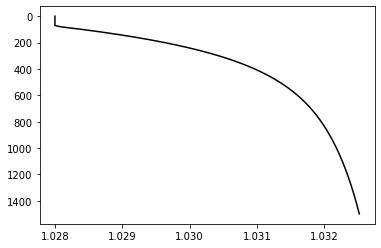

In [4]:
fig, ax = plt.subplots()
ax.plot(rho, depth, color = 'black')
ax.invert_yaxis()

In [5]:
Nsq_depth, Nsq = density2Nsq(depth, rho)
Nsq[Nsq==0] = 1e-9

In [6]:
(wmodes, pmodes, rmodes), ce, (dz_w, dz_p) = dynmodes(Nsq, Nsq_depth, 16)

Mode speeds do correspond: False


In [7]:
ds_pmodes =xr.DataArray(pmodes, dims=['nmode','depth'])
ds_modes = ds_pmodes.to_dataset(name='pmodes')
ds_modes['ce'] = ('nmode',ce)
ds_modes.coords['nmode'] = np.arange(pmodes.shape[0])
ds_modes.coords['depth'] = Nsq_depth[1:]

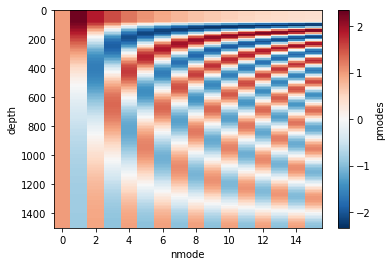

In [8]:
ds_modes.pmodes.plot(x='nmode', y='depth', yincrease=False)

In [9]:
A = np.amax(Nsq) * 0.55
H_n = 9.81 / ds_modes.ce.values**2
gamma = A / ds_modes.ce.values**2

In [10]:
def tau(x, y):
    """"Wind field according to Mccreary (1980)."""
    delta_x = abs(x[0, 0] - x[0, -1]) / 2
    delta_y = abs(y[0, 0] - y[-1, 0]) / 2

    wind_x = np.cos(np.pi * x / delta_x)
    wind_x[abs(x) > delta_x / 2] = 0

    wind_y = (1 + y**2 / delta_y**2) * np.exp( - y**2 / delta_y**2)

    return -5e-6 * wind_x * wind_y

In [11]:
from  multimodemodel import StaggeredGrid

c_grid = StaggeredGrid.regular_lat_lon_c_grid(
    lon_start=-50.0,
    lon_end=50.0,
    lat_start=-5.0,
    lat_end=5.0,
    nx=100 * 4 + 1,
    ny=10 * 4 + 1,
    z = np.array([0])
)

In [20]:
from multimodemodel import Parameters, f_on_sphere
params = []
for i in range(len(H_n)):
    params.append(
        Parameters(
            coriolis_func=f_on_sphere(omega=7.272205e-05),
            on_grid=c_grid,
            H=np.array([H_n[i]]),
            gamma = np.array([gamma[i]]),
        )
    )

In [21]:
from multimodemodel import (
    State, Variable,
 )

# tau_x = np.repeat(np.expand_dims(tau(c_grid.u.x, c_grid.u.y), axis=0), len(ds_modes.nmode), axis=0)
tau_x = np.expand_dims(tau(c_grid.u.x, c_grid.u.y), axis=0)
def zonal_wind(state, params):
    return State(u=Variable(tau_x /  params.rho_0, c_grid.u, np.datetime64("NaT")))

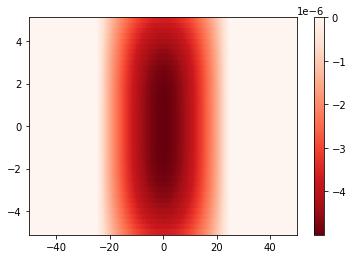

In [22]:
plt.figure()
plt.pcolormesh(c_grid.u.x, c_grid.u.y, tau_x[0], shading='auto', cmap='Reds_r')
plt.colorbar()

In [23]:
import functools as ft
import operator as op
from multimodemodel import (
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    laplacian_mixing_u, laplacian_mixing_v,
    linear_damping_v, linear_damping_u,
    linear_damping_eta
)

terms = [
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    laplacian_mixing_u, laplacian_mixing_v,
    linear_damping_v, linear_damping_u,
    linear_damping_eta, zonal_wind
]

def rhs(state, params):
    return ft.reduce(op.add, (term(state, params) for term in terms))

In [24]:
from multimodemodel import integrate, adams_bashforth3

time = 900.  # 15 min
step = c_grid.u.dx.min() / ds_modes.ce.values.max() / 4.  # applying CFL criterion with some safety net
t0 = np.datetime64("2000-01-01")

In [25]:
def run(params):
    model_run = integrate(
        State(
            u=Variable(None, c_grid.u, t0),
            v=Variable(None, c_grid.v, t0),
            eta=Variable(None, c_grid.eta, t0),
            q=Variable(None, c_grid.q, t0)
        ),
        params,
        RHS=rhs,
        scheme=adams_bashforth3,
        step=step,
        time=time,
    )
    
    Nt = time // step

    output = []

    for i, next_state in enumerate(model_run):
        if i % (Nt // 5) == 0:
            output.append(next_state.u)
    return output

In [26]:
from multiprocessing import Pool

pool = Pool()
out = pool.map(run, params) 

In [38]:
u_tildes = []
for i in range(len(out)):
    u_tilde = xr.combine_by_coords([u.as_dataarray for u in out[i]])
    u_tilde['z'] = np.array([i])
    u_tildes.append(u_tilde)
u_tilde =  xr.combine_by_coords(u_tildes)

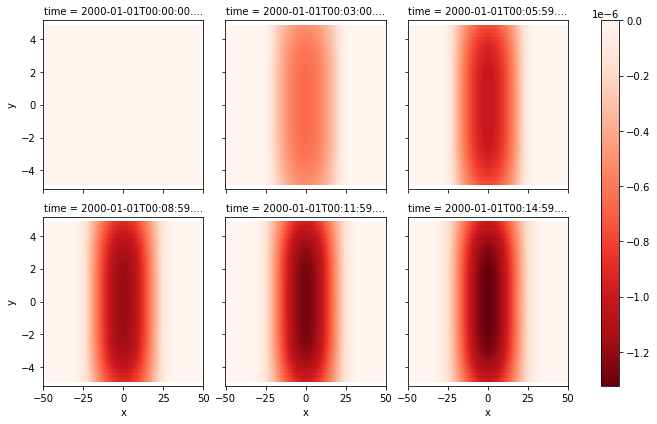

In [40]:
#u_tilde = xr.combine_by_coords([u.as_dataarray for u in output])

u_tilde.isel(z=14).plot(x='x', y='y', col="time", col_wrap=3, cmap='Reds_r');

In [41]:
ds_pmodes =xr.DataArray(pmodes, dims=['z','depth'])
ds_pmodes.coords['z'] = np.arange(pmodes.shape[0])
ds_pmodes.coords['depth'] = Nsq_depth[1:]

In [42]:
u = xr.dot(ds_pmodes, u_tilde)

Text(0.5, 1.02, 'u [m/s] at x = 0')

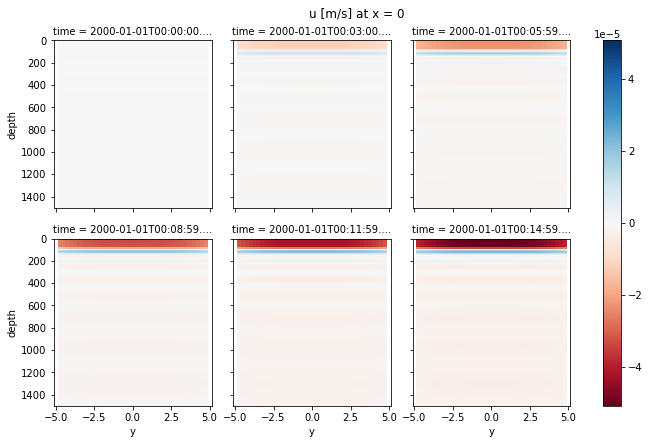

In [43]:
u.isel(i = 200).plot(x='y', y='depth', col="time", col_wrap=3, cmap='RdBu', yincrease=False);
plt.suptitle('u [m/s] at x = 0', y=1.02)